# YELP DATASET


## Goal
1. Rename columns
2. Reset Index
3. Get Restaurant Reviews + Businesses only
4. Get Users that have more than 50 reviews only
5. Clean Text ( lower , lemmatizing , remove punctuation )
5. Add Features to User Panda Frame
    - Elite Status --- 1: Yes 0:No
    - Add total user compliments 
    - Number of friends
    - Number of Tips Given --- Merge with tips pandaframe
    - Fill Null with 0 
7. Check to see continuous vs discrete data in pd

    

Dataset Source: https://www.yelp.com/dataset_challenge

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re, string
from collections import Counter

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


# Read Data

In [2]:
user = pd.read_csv('csv/user.csv')
business = pd.read_csv('csv/business.csv')
review = pd.read_csv('csv/review.csv')
tip = pd.read_csv('csv/tip.csv')

/Users/Charlotte/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def rename_column(file):
    new_names = list()
    for col in file:
        new_names.append(col.replace('.', '_', len(col)).replace(' ', '_', len(col)).lower())
    return new_names

In [4]:
user.columns = rename_column(user.columns)
business.columns = rename_column(business.columns)
business.columns = [ re.sub('attributes_', '', c) for c in business.columns ]
review.columns = rename_column(review.columns)

In [5]:
# user = user.ix[user['review_count'] > 50]
# business = business.ix[business['review_count'] > 50]

In [6]:
user = user.reset_index()
business = business.reset_index()

# Get Restaurants Businesses and Reviews

In [7]:
business.categories[:3]

0            ['Fast Food', 'Restaurants']
1                           ['Nightlife']
2    ['Active Life', 'Mini Golf', 'Golf']
Name: categories, dtype: object

In [8]:
# create a dataframe with business id and category
all_businesses = pd.concat([business['business_id'], business['categories']], axis=1, keys=['business_id', 'category'])

In [9]:
# get index of businesses that are not restaurants
not_restaurant = [i for i,e in enumerate(all_businesses.values) if "Restaurant" not in e[1]]

In [10]:
all_businesses.drop(all_businesses.index[not_restaurant], inplace=True)

In [11]:
restaurant = all_businesses # after dropping all businesses that are not restaurants business.tail(2)

In [12]:
restaurant = restaurant.reset_index() # reset the index 

In [13]:
restaurant.head(2)

,index,business_id,category
0,0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,3,mVHrayjG3uZ_RLHkLj-AMg,"['Bars', 'American (New)', 'Nightlife', 'Loung..."


In [14]:
len(review)

2685066

In [15]:
review_indices = review['business_id'].isin(restaurant['business_id'])

In [16]:
restaurant_review = review[review_indices]

In [17]:
count_reviews = pd.DataFrame(restaurant_review['business_id'].value_counts())
count_reviews = count_reviews.reset_index()

In [18]:
count_reviews.columns = ['business_id','count']

In [19]:
business_id = count_reviews['business_id'].ix[count_reviews['count'] > 400]

In [20]:
limited_index = restaurant_review['business_id'].isin(business_id)

In [21]:
restaurant_review = restaurant_review[limited_index]

In [22]:
restaurant_review = restaurant_review.reset_index()

In [23]:
#clean text data
def clean_text(x):
    wordnet = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    words =  [re.sub('['+string.punctuation+']', '', i.lower().replace('\n','')) for i in x.split()]
    lemmetized_words = [wordnet.lemmatize(word) for word in words if word not in stop  ]
    return " ".join(lemmetized_words)

In [24]:
restaurant_review['text'] = restaurant_review.text.apply(clean_text) #2/;24

In [25]:
clean_text(review['text'][0])

'mr hoagie institution walking seem like throwback 30 year ago old fashioned menu board booth 70 large selection food speciality italian hoagie voted best area year year usually order burger patty obviously cooked frozen ingredient fresh overall good alternative subway road'

# Add Features to User PD

In [26]:
user.head(2)

,index,yelping_since,compliments_plain,review_count,friends,compliments_cute,compliments_writer,fans,compliments_note,type,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
0,0,2004-10,25.0,108,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",15.0,9.0,69,20.0,user,...,3.0,"[2005, 2006]",Russel,18kPq7GPye-YQ3LyKyAZPw,246,NaN,167,14.0,11.0,282
1,1,2004-10,970.0,1292,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",204.0,346.0,1345,611.0,user,...,137.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,12091,38.0,8399,361.0,594.0,15242


In [27]:
# User membership period in days
user['yelping_period'] = [(pd.to_datetime('2016-11') - pd.Timestamp(i)).days for i in user['yelping_since'] ]

In [28]:
# Get the first year of elite status
user['elite_since'] = [i.replace('[','').replace(']','').split(',')[0] for i in user['elite']]
user['elite_since'] = [int(i) if i!= '' else 0 for i in user['elite_since'] ]

In [29]:
# Label members --- 1: Elite 0: None Elite
user['elite_status'] = [0 if i == 0 else 1 for i in user['elite_since']]

In [30]:
# Get number of friends 
user['n_friends'] = [len(i) for i in user['friends']]

In [31]:
# Count number of tips each user gives
tip_count = pd.DataFrame(tip['user_id'].value_counts())
tip_count = tip_count.reset_index()
tip_count.columns = ['user_id','tip_count']

In [32]:
# Merge tip count and user
user = user.merge(tip_count,how='left', left_on='user_id', right_on='user_id')

In [33]:
# aggregate all compliment features to one feature
comp_col = [i for i in list(user.columns) if 'compliments' in i]
user['compliments'] =user[comp_col].sum(axis = 1)

In [34]:
# Fill Null with 0 
user = user.fillna(0)

In [35]:
user.tail(2)

,index,yelping_since,compliments_plain,review_count,friends,compliments_cute,compliments_writer,fans,compliments_note,type,...,votes_funny,compliments_photos,compliments_funny,votes_useful,yelping_period,elite_since,elite_status,n_friends,tip_count,compliments
686554,686554,2016-02,0.0,1,[],0.0,0.0,0,0.0,user,...,0,0.0,0.0,2,274,0,0,2,0.0,0.0
686555,686555,2016-04,0.0,1,[],0.0,0.0,0,0.0,user,...,1,0.0,0.0,0,214,0,0,2,0.0,0.0


In [36]:
(user.columns)

Index(['index', 'yelping_since', 'compliments_plain', 'review_count',
       'friends', 'compliments_cute', 'compliments_writer', 'fans',
       'compliments_note', 'type', 'compliments_hot', 'compliments_cool',
       'compliments_profile', 'average_stars', 'compliments_more', 'elite',
       'name', 'user_id', 'votes_cool', 'compliments_list', 'votes_funny',
       'compliments_photos', 'compliments_funny', 'votes_useful',
       'yelping_period', 'elite_since', 'elite_status', 'n_friends',
       'tip_count', 'compliments'],
      dtype='object')

# Check all PD before Export

In [37]:
business = business.drop(['index','type'],axis = 1)

In [38]:
restaurant_review = restaurant_review.drop(['index','type'],axis = 1)

In [39]:
# drop unnecessary column 
user = user.drop(['index','type','name','friends','elite_since'],axis = 1)

In [40]:
user.head(2)

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful,yelping_period,elite_status,n_friends,tip_count,compliments
0,2004-10,25.0,108,15.0,9.0,69,20.0,48.0,76.0,8.0,...,0.0,167,14.0,11.0,282,4414,1,5200,0.0,229.0
1,2004-10,970.0,1292,204.0,346.0,1345,611.0,1111.0,1675.0,117.0,...,38.0,8399,361.0,594.0,15242,4414,1,50414,6.0,6164.0


In [41]:
restaurant_review.head(2)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,83ctfLRkC7roE1qOy0IuhA,FNnXv7iKidwPhu7dRgddsg,boy miss primate bros remember going packing d...,0,NeUf9FyCCIN4MEseNyqkXQ,0,4,2006-04-28,0
1,57ghQ4PJbGy-3LP7zSVnEg,odTD3ohAIP-i-hHqcUkd3A,pastrami cole slaw fry oh id heard hype place ...,1,NeUf9FyCCIN4MEseNyqkXQ,1,4,2007-09-24,1


In [42]:
business.head(2)

,ambience_divey,dietary_restrictions_vegan,happy_hour,hours_thursday_open,order_at_counter,hair_types_specialized_in_africanamerican,hair_types_specialized_in_kids,byob,hours_friday_open,good_for_latenight,...,noise_level,smoking,attire,hair_types_specialized_in_curly,good_for_groups,neighborhoods,open_24_hours,ambience_romantic,music_jukebox,ambience_upscale
0,False,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,False,...,average,NaN,casual,NaN,True,[],NaN,False,NaN,False
1,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,[],NaN,NaN,NaN,NaN


In [43]:
tip.head(1)

,user_id,text,business_id,likes,date,type
0,ZxdojCZgZhw36xuSGaryRg,Pizza is garbage. Hoagies are excellent.,5UmKMjUEUNdYWqANhGckJw,0,2016-07-17,tip


# Minor Tweak

In [44]:
print(1)

1


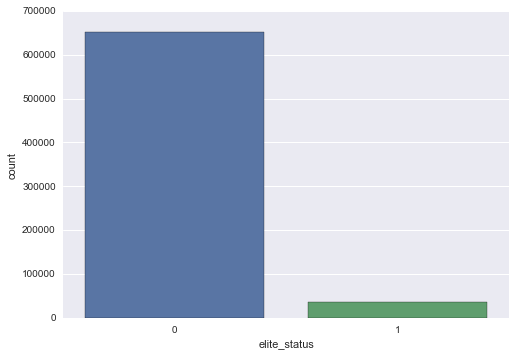

In [45]:
sns.countplot(user['elite_status'])

In [46]:
1 - mean(user['elite_status'])

0.9478615000087393

In [47]:
len(user)

686556

In [48]:
test =  user.ix[user['review_count'] > 40]

In [49]:
len(test)

85925

In [50]:
1 - mean(test['elite_status'])

0.5955891766075065

# Export to pickle

In [51]:
restaurant_review.to_pickle('data/review') 
business.to_pickle('data/business')
user.to_pickle('data/user')


In [52]:
checking = pd.read_pickle('data/user')

In [53]:
checking.head(2)

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful,yelping_period,elite_status,n_friends,tip_count,compliments
0,2004-10,25.0,108,15.0,9.0,69,20.0,48.0,76.0,8.0,...,0.0,167,14.0,11.0,282,4414,1,5200,0.0,229.0
1,2004-10,970.0,1292,204.0,346.0,1345,611.0,1111.0,1675.0,117.0,...,38.0,8399,361.0,594.0,15242,4414,1,50414,6.0,6164.0
